<h1>Encodings for Next Step Activity Prediction</h1>

<h5>Lorenzo Manuel Cirac Monteagudo</h5>
<h5>Supervisor: Ana Luisa Oliveira da Nobrega Costa</h5>
<h5>Chair: Information Systems</h5>
<h5>TUM School of Computation, Information and Technology</h5>

In [1]:
DATA = "Helpdesk"
RANDOM_STATE = 2025
MAX_CASES = 10000
MAX_CASE_LENGTH = 10

In [2]:
import pandas as pd
import numpy as np
import pm4py
import random
import matplotlib.pyplot as plt
import warnings
random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore")

<h3>Dataset Exploration</h3>
<p>Helpdesk dataset: <a href="https://github.com/ERamaM/PredictiveMonitoringDatasets/tree/master/raw_datasets">https://github.com/ERamaM/PredictiveMonitoringDatasets/tree/master/raw_datasets</a></p>
<p>This dataset contains events from a ticketing management process of the help desk of an Italian software company. </p>

In [3]:
from pm4py.objects.conversion.log import converter as xes_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

log = xes_importer.apply(f"data/{DATA}.xes")
df = xes_converter.apply(log, variant=xes_converter.Variants.TO_DATA_FRAME)

parsing log, completed traces ::   0%|          | 0/4580 [00:00<?, ?it/s]

In [4]:
df.columns

Index(['concept:name', 'lifecycle:transition', 'org:resource',
       'time:timestamp', 'Activity', 'Resource', 'case:concept:name',
       'case:variant', 'case:variant-index', 'case:creator'],
      dtype='object')

In [5]:
df["concept:name"].unique()

array(['Assign seriousness', 'Take in charge ticket', 'Resolve ticket',
       'Closed', 'Wait', 'Create SW anomaly', 'Insert ticket',
       'Schedule intervention', 'RESOLVED', 'INVALID', 'VERIFIED',
       'Resolve SW anomaly', 'Require upgrade', 'DUPLICATE'], dtype=object)

In [6]:
from collections import Counter, defaultdict

# basic stats
total_events = sum(len(trace) for trace in log)
print(f"Cases: {len(log)}")
print(f"Events: {total_events}")
print(f"Activities: {len(pm4py.get_event_attribute_values(log, "concept:name"))}")
print(f"Variants: {len(pm4py.stats.get_variants(log))}")
print(f"Average case length: {total_events / len(log):.2f} events per case")

# top 5 most common activities
activities = pm4py.get_event_attribute_values(log, "concept:name")
activity_counter = Counter(activities)
print("\nMost common activities:")
for i, (activity, count) in enumerate(activity_counter.most_common(5), 1):
    print(f"{i}. {activity}: {count}")

# most common activities by position
positions = defaultdict(Counter)
for trace in log:
    for position, event in enumerate(trace):
        positions[position][event["concept:name"]] += 1

print("\nMost common by position:")
for position in range(min(5, len(positions))):
    if position in positions:
        activity, count = positions[position].most_common(1)[0]
        percentage = count / len(log) * 100
        print(f"{position + 1}. {activity} ({count} cases, {percentage:.1f}%)")

Cases: 4580
Events: 21348
Activities: 14
Variants: 226
Average case length: 4.66 events per case

Most common activities:
1. Take in charge ticket: 5060
2. Resolve ticket: 4983
3. Assign seriousness: 4938
4. Closed: 4574
5. Wait: 1463

Most common by position:
1. Assign seriousness (4384 cases, 95.7%)
2. Take in charge ticket (3712 cases, 81.0%)
3. Resolve ticket (2713 cases, 59.2%)
4. Closed (2504 cases, 54.7%)
5. Closed (1091 cases, 23.8%)


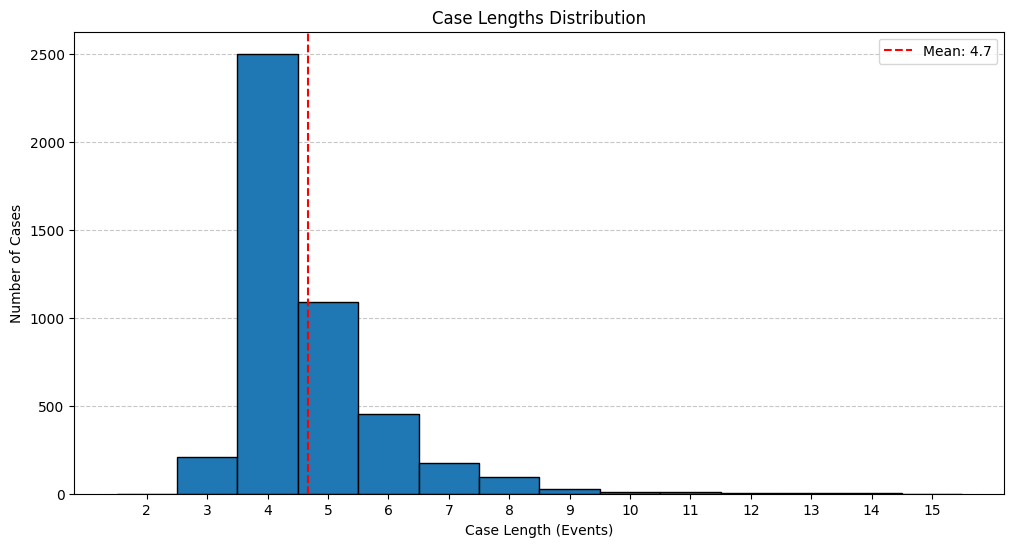

In [7]:
case_lengths = df.groupby("case:concept:name").size()
mean_length = case_lengths.mean()

min_length = case_lengths.min()
max_length = case_lengths.max()
bins = np.arange(min_length - 0.5, max_length + 1.5, 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_axisbelow(True)
ax.hist(case_lengths, bins=bins, edgecolor="black", align="mid")
ax.axvline(mean_length, color="red", linestyle="--", label=f"Mean: {mean_length:.1f}")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_title("Case Lengths Distribution")
ax.set_xlabel("Case Length (Events)")
ax.set_ylabel("Number of Cases")
ax.set_xticks(np.arange(min_length, max_length + 1, 1))

ax.legend()
plt.show()

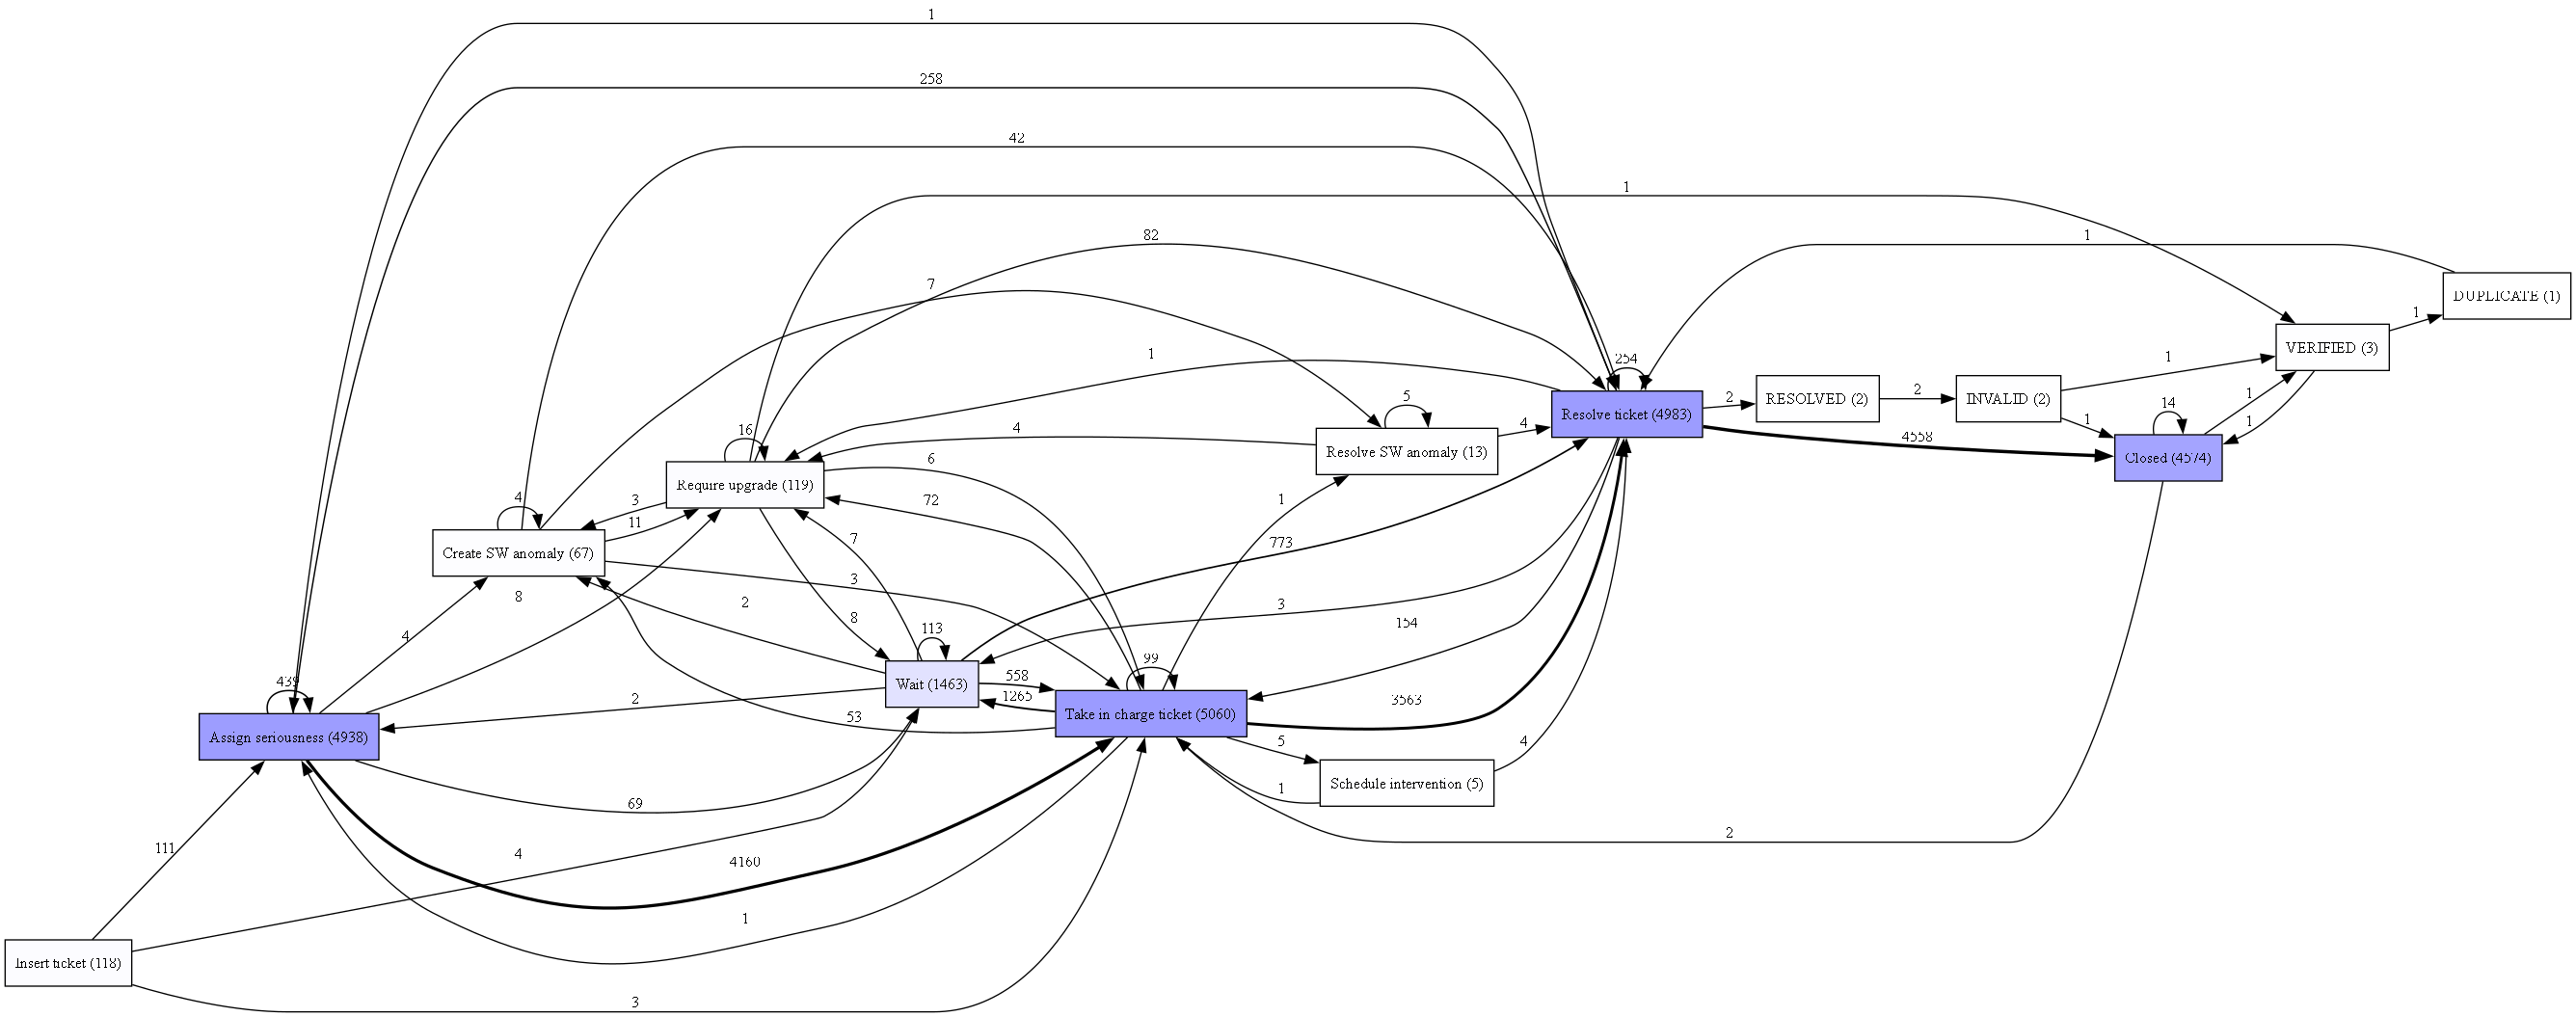

In [8]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_vis

dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.FREQUENCY)
gviz = dfg_vis.apply(dfg, log=log, variant=dfg_vis.Variants.FREQUENCY)

dfg_vis.view(gviz)

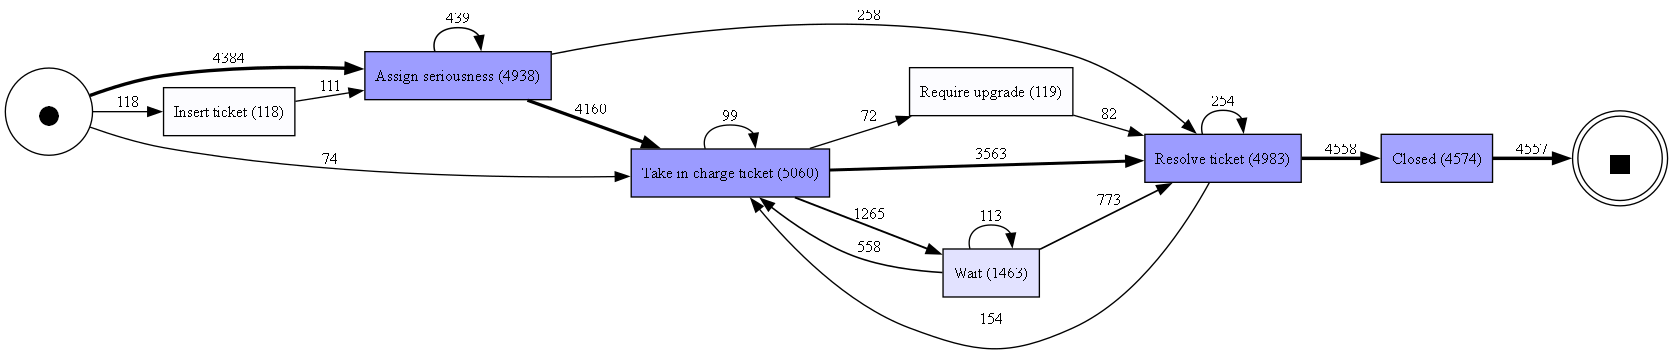

In [9]:
from pm4py.algo.filtering.dfg import dfg_filtering
from pm4py.statistics.attributes.log import get as attributes_get
from pm4py.statistics.start_activities.log import get as start_activities_get
from pm4py.statistics.end_activities.log import get as end_activities_get

start_activities = start_activities_get.get_start_activities(log)
end_activities = end_activities_get.get_end_activities(log)
activities_count = attributes_get.get_attribute_values(log, "concept:name")

# filter the dfg to keep 25% of paths
filtered_dfg, filtered_start_activities, filtered_end_activities, filtered_activities_count = \
    dfg_filtering.filter_dfg_on_paths_percentage(
        dfg, 
        start_activities, 
        end_activities, 
        activities_count, 
        0.25
    )

gviz = dfg_vis.apply(filtered_dfg, 
                     log=log, 
                     variant=dfg_vis.Variants.FREQUENCY,
                     parameters={"start_activities": filtered_start_activities,
                               "end_activities": filtered_end_activities})
dfg_vis.view(gviz)

In [10]:
unique_cases = df["case:concept:name"].unique()
if len(unique_cases) > MAX_CASES:
    sampled_case_ids = pd.Series(unique_cases).sample(n=MAX_CASES, random_state=2025)
    df = df[df["case:concept:name"].isin(sampled_case_ids)]

df = df.groupby("case:concept:name").head(MAX_CASE_LENGTH).reset_index(drop=True)

<h3>Data Preparation</h3>

In [11]:
# clean data
df = df.rename(columns = {
    "case:concept:name": "case_id",
    "concept:name": "activity", 
    "org:resource": "resource",
    "time:timestamp": "timestamp"
})

required_cols = ["case_id", "activity", "timestamp"]
optional_cols = ["resource"]
cols_to_select = required_cols.copy()
for col in optional_cols:
    if col in df.columns:
        cols_to_select.append(col)
        
df = df[cols_to_select]

# target (y)
df["next_activity"] = df.groupby("case_id")["activity"].shift(-1)

# sort by timestamp
df = df.sort_values(by = ["case_id", "timestamp"])

df.head()

,case_id,activity,timestamp,resource,next_activity
17582,Case1,Assign seriousness,2012-10-09 14:50:17+00:00,Value 1,Take in charge ticket
17583,Case1,Take in charge ticket,2012-10-09 14:51:01+00:00,Value 1,Take in charge ticket
17584,Case1,Take in charge ticket,2012-10-12 15:02:56+00:00,Value 2,Resolve ticket
17585,Case1,Resolve ticket,2012-10-25 11:54:26+00:00,Value 1,Closed
17586,Case1,Closed,2012-11-09 12:54:39+00:00,Value 3,NaN


In [12]:
# prefix traces
prefixes = []
for case_id, group in df.groupby("case_id"):
    activities = group["activity"].astype(str).tolist()
    resources = group["resource"].astype(str).tolist() if "resource" in group.columns else ["Unknown"] * len(group)
    timestamps = group["timestamp"].tolist()
    
    case_start_time = timestamps[0]
    
    for i in range(1, len(activities)):   
        current_timestamp = timestamps[i-1]
        
        # time since start (hours)
        time_since_start = (current_timestamp - case_start_time).total_seconds() / 3600
        
        # time since previous (hours)
        if i == 1:
            time_since_previous = 0.0
        else:
            previous_timestamp = timestamps[i-2]
            time_since_previous = (current_timestamp - previous_timestamp).total_seconds() / 3600
        
        prefixes.append({
            "case_id": case_id,
            "step": i,
            "activities": activities[:i],
            "resources": resources[:i],
            "time_since_start": time_since_start,
            "time_since_previous": time_since_previous,
            "next_activity": activities[i],
        })

# fix types
df = pd.DataFrame(prefixes)
df["case_id"] = df["case_id"].astype(str)
df["step"] = df["step"].astype(float)
df["activities"] = df["activities"].astype(object)
df["resources"] = df["resources"].astype(object)  
df["time_since_start"] = df["time_since_start"].astype(float)
df["time_since_previous"] = df["time_since_previous"].astype(float)
df["next_activity"] = df["next_activity"].astype(str)

df

,case_id,step,activities,resources,time_since_start,time_since_previous,next_activity
0,Case1,1.0,[Assign seriousness],[Value 1],0.000000,0.000000,Take in charge ticket
1,Case1,2.0,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 1]",0.012222,0.012222,Take in charge ticket
2,Case1,3.0,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2]",72.210833,72.198611,Resolve ticket
3,Case1,4.0,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2, Value 1]",381.069167,308.858333,Closed
4,Case10,1.0,[Assign seriousness],[Value 2],0.000000,0.000000,Take in charge ticket
...,...,...,...,...,...,...,...
16729,Case998,3.0,"[Assign seriousness, Take in charge ticket, Wait]","[Value 9, Value 2, Value 9]",93.970556,93.963611,Resolve ticket
16730,Case998,4.0,"[Assign seriousness, Take in charge ticket, Wa...","[Value 9, Value 2, Value 9, Value 9]",484.906111,390.935556,Closed
16731,Case999,1.0,[Assign seriousness],[Value 1],0.000000,0.000000,Take in charge ticket
16732,Case999,2.0,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 12]",307.511944,307.511944,Resolve ticket


<h3>Feature Selection</h3>

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df.drop(columns = ["case_id", "next_activity"])
y = df["next_activity"]

le = LabelEncoder()
y = le.fit_transform(df["next_activity"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [14]:
X

,step,activities,resources,time_since_start,time_since_previous
0,1.0,[Assign seriousness],[Value 1],0.000000,0.000000
1,2.0,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 1]",0.012222,0.012222
2,3.0,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2]",72.210833,72.198611
3,4.0,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2, Value 1]",381.069167,308.858333
4,1.0,[Assign seriousness],[Value 2],0.000000,0.000000
...,...,...,...,...,...
16729,3.0,"[Assign seriousness, Take in charge ticket, Wait]","[Value 9, Value 2, Value 9]",93.970556,93.963611
16730,4.0,"[Assign seriousness, Take in charge ticket, Wa...","[Value 9, Value 2, Value 9, Value 9]",484.906111,390.935556
16731,1.0,[Assign seriousness],[Value 1],0.000000,0.000000
16732,2.0,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 12]",307.511944,307.511944


<h3>Encodings</h3>

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder

<h4>One-hot Encoding</h4>
<p>One-hot encoding converts categorical data into a numerical format by creating one binary feature per unique category. Each feature indicates the presence (1) or absence (0) of the category in the observation.</p>

In [16]:
def one_hot_encoding(X_train, X_test):
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    
    numerical_cols = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]
    non_numerical_cols = [col for col in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[col])]
    
    encoded_train_dfs = []
    encoded_test_dfs = []
    
    for col in non_numerical_cols:
        mlb = MultiLabelBinarizer()
        mlb.fit(X_train_copy[col])
        train_encoded_data = mlb.transform(X_train_copy[col])
        test_encoded_data = mlb.transform(X_test_copy[col])
        col_names = [f"{col}_{cls}" for cls in mlb.classes_]
        train_encoded_df = pd.DataFrame(train_encoded_data, columns=col_names, index=X_train_copy.index)
        test_encoded_df = pd.DataFrame(test_encoded_data, columns=col_names, index=X_test_copy.index)
        encoded_train_dfs.append(train_encoded_df)
        encoded_test_dfs.append(test_encoded_df)
    
    if numerical_cols:
        encoded_train_dfs.append(X_train_copy[numerical_cols])
        encoded_test_dfs.append(X_test_copy[numerical_cols])
    
    X_train_encoded = pd.concat(encoded_train_dfs, axis=1)
    X_test_encoded = pd.concat(encoded_test_dfs, axis=1)
    
    return X_train_encoded, X_test_encoded

In [17]:
one_hot_encoding(X_train, X_test)[0]

,activities_Assign seriousness,activities_Closed,activities_Create SW anomaly,activities_DUPLICATE,activities_INVALID,activities_Insert ticket,activities_RESOLVED,activities_Require upgrade,activities_Resolve SW anomaly,activities_Resolve ticket,...,resources_Value 3,resources_Value 4,resources_Value 5,resources_Value 6,resources_Value 7,resources_Value 8,resources_Value 9,step,time_since_start,time_since_previous
12439,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3.0,91.086389,91.083611
9657,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3.0,504.043611,336.908611
10441,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2.0,0.130556,0.130556
6974,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.000000,0.000000
9016,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2.0,0.148333,0.148333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3.0,0.063333,0.048056
16707,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3.0,523.545833,0.016111
15948,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,6.0,1058.316111,0.016389
11102,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,4.0,169.650278,97.987222


<h4>Last State Encoding</h4>
<p>Last state encoding represents only the most recent events in a sequence. The last n events are selected, and each position is separately one-hot encoded to preserve their order.</p>

In [18]:

def last_state_encoding(X_train, X_test, n=1):
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    numerical_cols = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]
    non_numerical_cols = [col for col in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[col])]
    
    def extract_last_state(data):
        features = {}
        for col in numerical_cols:
            features[col] = data[col]
        
        for col in non_numerical_cols:
            last_states = data[col].apply(
                lambda x: (["None"] * max(0, n - len(x)) + x)[-n:]
            )
            for i in range(n):
                features[f"last_{col}_{i+1}"] = last_states.apply(lambda x: x[i])
        
        return pd.DataFrame(features, index=data.index)
    
    X_train_new = extract_last_state(X_train_copy)
    X_test_new = extract_last_state(X_test_copy)
    
    categorical_cols = [col for col in X_train_new.columns if col not in numerical_cols]
    
    encoded_train_dfs = []
    encoded_test_dfs = []
    
    if categorical_cols:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=int)
        encoder.fit(X_train_new[categorical_cols])
        train_encoded_data = encoder.transform(X_train_new[categorical_cols])
        test_encoded_data = encoder.transform(X_test_new[categorical_cols])
        col_names = encoder.get_feature_names_out(categorical_cols)
        train_encoded_df = pd.DataFrame(train_encoded_data, columns=col_names, index=X_train_new.index)
        test_encoded_df = pd.DataFrame(test_encoded_data, columns=col_names, index=X_test_new.index)
        encoded_train_dfs.append(train_encoded_df)
        encoded_test_dfs.append(test_encoded_df)
    if numerical_cols:
        encoded_train_dfs.append(X_train_new[numerical_cols])
        encoded_test_dfs.append(X_test_new[numerical_cols])
    
    X_train_encoded = pd.concat(encoded_train_dfs, axis=1)
    X_test_encoded = pd.concat(encoded_test_dfs, axis=1)
    
    return X_train_encoded, X_test_encoded

In [19]:
last_state_encoding(X_train, X_test)[0]

,last_activities_1_Assign seriousness,last_activities_1_Closed,last_activities_1_Create SW anomaly,last_activities_1_DUPLICATE,last_activities_1_INVALID,last_activities_1_Insert ticket,last_activities_1_RESOLVED,last_activities_1_Require upgrade,last_activities_1_Resolve SW anomaly,last_activities_1_Resolve ticket,...,last_resources_1_Value 3,last_resources_1_Value 4,last_resources_1_Value 5,last_resources_1_Value 6,last_resources_1_Value 7,last_resources_1_Value 8,last_resources_1_Value 9,step,time_since_start,time_since_previous
12439,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3.0,91.086389,91.083611
9657,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3.0,504.043611,336.908611
10441,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2.0,0.130556,0.130556
6974,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.000000,0.000000
9016,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2.0,0.148333,0.148333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3.0,0.063333,0.048056
16707,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3.0,523.545833,0.016111
15948,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,6.0,1058.316111,0.016389
11102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4.0,169.650278,97.987222


<h4>Index Encoding</h4>
<p>Index encoding assigns each event to its specific position in the trace, treating each position as a separate feature. One-hot encoding is applied at each position to fully preserve the event order.</p>

In [20]:
def index_encoding(X_train, X_test, max_length=MAX_CASE_LENGTH):
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    numerical_cols = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]
    non_numerical_cols = [col for col in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[col])]
    
    if max_length is None:
        max_length = max([X_train_copy[col].apply(len).max() for col in non_numerical_cols])
    
    encoded_train_dfs = []
    encoded_test_dfs = []
    
    for col in non_numerical_cols:
        all_values = set()
        for seq in X_train_copy[col]:
            all_values.update(seq)
        all_values.add("None")
        all_values = sorted(list(all_values))
        
        for i in range(max_length):
            train_position_data = X_train_copy[col].apply(
                lambda x: x[i] if i < len(x) else "None"
            )
            test_position_data = X_test_copy[col].apply(
                lambda x: x[i] if i < len(x) else "None"
            )
            
            encoder = OneHotEncoder(categories=[all_values], handle_unknown="ignore", sparse_output=False, dtype=int)
            encoder.fit(train_position_data.values.reshape(-1, 1))
            train_encoded_data = encoder.transform(train_position_data.values.reshape(-1, 1))
            test_encoded_data = encoder.transform(test_position_data.values.reshape(-1, 1))
            
            col_names = [f"{col}_{i+1}_{val}" for val in all_values]
            train_encoded_df = pd.DataFrame(train_encoded_data, columns=col_names, index=X_train_copy.index)
            test_encoded_df = pd.DataFrame(test_encoded_data, columns=col_names, index=X_test_copy.index)
            encoded_train_dfs.append(train_encoded_df)
            encoded_test_dfs.append(test_encoded_df)
    
    if numerical_cols:
        encoded_train_dfs.append(X_train_copy[numerical_cols])
        encoded_test_dfs.append(X_test_copy[numerical_cols])
    
    X_train_encoded = pd.concat(encoded_train_dfs, axis=1)
    X_test_encoded = pd.concat(encoded_test_dfs, axis=1)
    
    return X_train_encoded, X_test_encoded

In [21]:
index_encoding(X_train, X_test)[0]

,activities_1_Assign seriousness,activities_1_Closed,activities_1_Create SW anomaly,activities_1_DUPLICATE,activities_1_INVALID,activities_1_Insert ticket,activities_1_None,activities_1_RESOLVED,activities_1_Require upgrade,activities_1_Resolve SW anomaly,...,resources_10_Value 3,resources_10_Value 4,resources_10_Value 5,resources_10_Value 6,resources_10_Value 7,resources_10_Value 8,resources_10_Value 9,step,time_since_start,time_since_previous
12439,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,91.086389,91.083611
9657,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,504.043611,336.908611
10441,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,0.130556,0.130556
6974,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.000000,0.000000
9016,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,0.148333,0.148333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,0.063333,0.048056
16707,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,523.545833,0.016111
15948,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.0,1058.316111,0.016389
11102,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.0,169.650278,97.987222


<h4>Inter Case Encoding</h4>
<p>Inter-case encoding adds contextual information from other running cases to each event’s representation.</p>

In [22]:
def inter_case_encoding(X_train, X_test):
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    numerical_cols = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]
    non_numerical_cols = [col for col in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[col])]
    
    frequency_features_train = {}
    frequency_features_test = {}
    
    for col in non_numerical_cols:
        train_col_values = X_train_copy[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)
        frequency_counts = train_col_values.value_counts().to_dict()
        
        test_col_values = X_test_copy[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)
        
        frequency_features_train[f"{col}_frequency"] = train_col_values.apply(lambda x: frequency_counts[x])
        frequency_features_test[f"{col}_frequency"] = test_col_values.apply(lambda x: frequency_counts.get(x, 0))
    
    frequency_train_df = pd.DataFrame(frequency_features_train, index=X_train_copy.index)
    frequency_test_df = pd.DataFrame(frequency_features_test, index=X_test_copy.index)
    
    encoded_train_dfs = []
    encoded_test_dfs = []
    
    if frequency_features_train:
        encoded_train_dfs.append(frequency_train_df)
        encoded_test_dfs.append(frequency_test_df)
    
    for col in non_numerical_cols:
        mlb = MultiLabelBinarizer()
        mlb.fit(X_train_copy[col])
        train_encoded_data = mlb.transform(X_train_copy[col])
        test_encoded_data = mlb.transform(X_test_copy[col])
        col_names = [f"{col}_{cls}" for cls in mlb.classes_]
        train_encoded_df = pd.DataFrame(train_encoded_data, columns=col_names, index=X_train_copy.index)
        test_encoded_df = pd.DataFrame(test_encoded_data, columns=col_names, index=X_test_copy.index)
        encoded_train_dfs.append(train_encoded_df)
        encoded_test_dfs.append(test_encoded_df)
    
    if numerical_cols:
        encoded_train_dfs.append(X_train_copy[numerical_cols])
        encoded_test_dfs.append(X_test_copy[numerical_cols])
    
    X_train_encoded = pd.concat(encoded_train_dfs, axis=1)
    X_test_encoded = pd.concat(encoded_test_dfs, axis=1)
    
    return X_train_encoded, X_test_encoded

In [23]:
inter_case_encoding(X_train, X_test)[0]

,activities_frequency,resources_frequency,activities_Assign seriousness,activities_Closed,activities_Create SW anomaly,activities_DUPLICATE,activities_INVALID,activities_Insert ticket,activities_RESOLVED,activities_Require upgrade,...,resources_Value 3,resources_Value 4,resources_Value 5,resources_Value 6,resources_Value 7,resources_Value 8,resources_Value 9,step,time_since_start,time_since_previous
12439,2057,98,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,91.086389,91.083611
9657,2057,15,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,504.043611,336.908611
10441,2965,4,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2.0,0.130556,0.130556
6974,3490,1229,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.000000,0.000000
9016,304,323,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2.0,0.148333,0.148333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,243,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3.0,0.063333,0.048056
16707,2057,8,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,523.545833,0.016111
15948,1,17,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.0,1058.316111,0.016389
11102,63,54,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4.0,169.650278,97.987222


<h4>Aggregation Encoding</h4>
<p>Aggregation encoding summarizes the entire prefix trace by computing statistical features over the sequence.</p>

In [24]:
from collections import Counter
from itertools import combinations

def aggregation_encoding(X_train, X_test):
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    numerical_cols = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]
    non_numerical_cols = [col for col in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[col])]
    
    def compute_aggregation_features(data):
        features = {}
        
        for col in non_numerical_cols:
            col_data = data[col]
            features[f"unique_{col}"] = col_data.apply(lambda x: len(set(x)) if x else 0)
            features[f"most_frequent_{col}_count"] = col_data.apply(
                lambda x: max(Counter(x).values()) if x else 0
            )
        
        for col1, col2 in combinations(non_numerical_cols, 2):
            features[f"{col1}_{col2}_ratio"] = data.apply(
                lambda row: len(set(row[col1])) / len(set(row[col2])) if len(set(row[col2])) > 0 else 0,
                axis=1
            )
        for col in numerical_cols:
            features[col] = data[col]
        
        return pd.DataFrame(features, index=data.index)
    
    X_train_encoded = compute_aggregation_features(X_train_copy)
    X_test_encoded = compute_aggregation_features(X_test_copy)
    
    return X_train_encoded, X_test_encoded

In [25]:
aggregation_encoding(X_train, X_test)[0]

,unique_activities,most_frequent_activities_count,unique_resources,most_frequent_resources_count,activities_resources_ratio,step,time_since_start,time_since_previous
12439,3,1,1,3,3.0,3.0,91.086389,91.083611
9657,3,1,2,2,1.5,3.0,504.043611,336.908611
10441,2,1,2,1,1.0,2.0,0.130556,0.130556
6974,1,1,1,1,1.0,1.0,0.000000,0.000000
9016,1,2,1,2,1.0,2.0,0.148333,0.148333
...,...,...,...,...,...,...,...,...
5331,2,2,2,2,1.0,3.0,0.063333,0.048056
16707,3,1,2,2,1.5,3.0,523.545833,0.016111
15948,3,4,1,6,3.0,6.0,1058.316111,0.016389
11102,3,2,2,3,1.5,4.0,169.650278,97.987222


<h4>Embeddings</h4>
<p>Embeddings are dense, low-dimensional numerical representations of categorical or textual data that capture the semantic meaning or relationships between items.</p>

In [26]:
from sentence_transformers import SentenceTransformer

def embedding_encoding(X_train, X_test, model_name="all-MiniLM-L12-v1"):
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    numerical_cols = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]
    non_numerical_cols = [col for col in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[col])]
    
    def lists_to_string(series):
        return series.apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
    
    model = SentenceTransformer(model_name)
    encoded_train_dfs = []
    encoded_test_dfs = []
    
    for col in non_numerical_cols:
        train_col_str = lists_to_string(X_train_copy[col])
        test_col_str = lists_to_string(X_test_copy[col])
        
        train_unique_values = train_col_str.unique()
        test_unique_values = test_col_str.unique()
        all_unique_values = np.unique(np.concatenate([train_unique_values, test_unique_values]))
        
        print(f"Column '{col}': {len(train_col_str)} train values, {len(train_unique_values)} train unique, {len(test_col_str)} test values, {len(test_unique_values)} test unique")
        
        unique_embeddings = model.encode(all_unique_values.tolist())
        value_to_embedding = dict(zip(all_unique_values, unique_embeddings))
        
        train_embedding_series = train_col_str.map(value_to_embedding)
        test_embedding_series = test_col_str.map(value_to_embedding)
        
        train_embeddings = np.vstack(train_embedding_series.values)
        test_embeddings = np.vstack(test_embedding_series.values)
        embedding_dim = train_embeddings.shape[1]
        col_names = [f"{col}_emb_{i}" for i in range(embedding_dim)]
        
        train_encoded_df = pd.DataFrame(train_embeddings, columns=col_names, index=X_train_copy.index)
        test_encoded_df = pd.DataFrame(test_embeddings, columns=col_names, index=X_test_copy.index)
        encoded_train_dfs.append(train_encoded_df)
        encoded_test_dfs.append(test_encoded_df)
    
    if numerical_cols:
        encoded_train_dfs.append(X_train_copy[numerical_cols])
        encoded_test_dfs.append(X_test_copy[numerical_cols])
    
    X_train_encoded = pd.concat(encoded_train_dfs, axis=1)
    X_test_encoded = pd.concat(encoded_test_dfs, axis=1)
    
    return X_train_encoded, X_test_encoded

In [27]:
embedding_encoding(X_train, X_test)[0]

Column 'activities': 13387 train values, 415 train unique, 3347 test values, 194 test unique
Column 'resources': 13387 train values, 1795 train unique, 3347 test values, 721 test unique


,activities_emb_0,activities_emb_1,activities_emb_2,activities_emb_3,activities_emb_4,activities_emb_5,activities_emb_6,activities_emb_7,activities_emb_8,activities_emb_9,...,resources_emb_377,resources_emb_378,resources_emb_379,resources_emb_380,resources_emb_381,resources_emb_382,resources_emb_383,step,time_since_start,time_since_previous
12439,0.007586,0.045566,-0.035497,0.012859,0.054820,-0.087651,0.146754,0.023535,-0.015497,0.039748,...,0.055535,-0.084177,-0.006674,0.096114,-0.025081,0.011009,-0.025698,3.0,91.086389,91.083611
9657,0.007586,0.045566,-0.035497,0.012859,0.054820,-0.087651,0.146754,0.023535,-0.015497,0.039748,...,0.038269,0.002892,-0.018789,0.076176,-0.008727,0.068497,-0.068492,3.0,504.043611,336.908611
10441,0.031616,0.019340,-0.035116,-0.014152,0.105390,-0.045988,0.140856,0.019199,-0.027401,0.021267,...,0.044272,-0.011656,0.004631,0.074209,-0.059757,-0.004960,-0.004824,2.0,0.130556,0.130556
6974,0.003831,0.005129,-0.051551,-0.021871,0.069599,-0.053350,0.081832,0.026582,-0.047898,0.008342,...,0.031404,-0.010499,0.013916,0.066067,-0.017299,0.024202,-0.018716,1.0,0.000000,0.000000
9016,0.002870,-0.002491,-0.058515,-0.009875,0.058555,-0.055893,0.103054,-0.006209,-0.053405,0.003642,...,0.037987,-0.009380,-0.032797,0.051304,-0.035227,0.036654,-0.041731,2.0,0.148333,0.148333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,0.034601,0.023019,-0.048343,-0.021035,0.090179,-0.064461,0.147294,0.002200,-0.050229,0.018805,...,0.054828,-0.018639,-0.038568,0.069700,-0.026056,-0.022714,-0.037194,3.0,0.063333,0.048056
16707,0.007586,0.045566,-0.035497,0.012859,0.054820,-0.087651,0.146754,0.023535,-0.015497,0.039748,...,0.040481,0.000796,-0.008998,0.046790,-0.067699,-0.007170,-0.042992,3.0,523.545833,0.016111
15948,0.027853,0.028067,-0.051992,-0.013728,0.069336,-0.084618,0.147929,0.012899,-0.048720,0.031243,...,0.038782,0.004912,-0.024186,0.068553,0.013281,-0.006148,-0.071148,6.0,1058.316111,0.016389
11102,0.031825,0.053042,-0.044356,-0.000265,0.057297,-0.073940,0.162434,0.000072,0.003517,0.043822,...,0.029656,-0.022986,-0.014530,0.085140,-0.015308,0.029589,-0.060864,4.0,169.650278,97.987222


<h3>Evaluation</h3>

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import time

results = []

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
}

encodings = [
    one_hot_encoding, 
    last_state_encoding,
    index_encoding,
    inter_case_encoding,
    aggregation_encoding, 
    embedding_encoding
]

for encoding in encodings:

    encoding_start = time.perf_counter()
    X_train_encoded, X_test_encoded = encoding(X_train, X_test)
    encoding_time = time.perf_counter() - encoding_start
    
    training_start = time.perf_counter()
    rf = RandomForestClassifier(random_state=RANDOM_STATE)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1)
    grid_search.fit(X_train_encoded, y_train)
    training_time = time.perf_counter() - training_start
    
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train_encoded)
    y_test_pred = best_model.predict(X_test_encoded)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    
    print(f"=== {encoding.__name__} ===")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Encoding Time: {encoding_time:.2f}s, Training Time: {training_time:.2f}s")
    print(f"Train: Accuracy={train_accuracy:.4f}, F1={train_f1:.4f}")
    print(f"Test:  Accuracy={test_accuracy:.4f}, F1={test_f1:.4f}")
    print()
    
    results.append({
        "encoding": encoding.__name__,
        "encoding_time": encoding_time,
        "training_time": training_time,
        "total_time": encoding_time + training_time,
        "best_params": grid_search.best_params_,
        "model": best_model,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_f1": train_f1,
        "test_f1": test_f1,
        "accuracy_gap": train_accuracy - test_accuracy,
        "f1_gap": train_f1 - test_f1
    })

=== one_hot_encoding ===
Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Encoding Time: 0.03s, Training Time: 36.62s
Train: Accuracy=0.8483, F1=0.8304
Test:  Accuracy=0.7900, F1=0.7655

=== last_state_encoding ===
Best Params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
Encoding Time: 0.25s, Training Time: 29.25s
Train: Accuracy=0.8382, F1=0.8111
Test:  Accuracy=0.7983, F1=0.7647

=== index_encoding ===
Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Encoding Time: 0.25s, Training Time: 63.69s
Train: Accuracy=0.8625, F1=0.8462
Test:  Accuracy=0.8001, F1=0.7765

=== inter_case_encoding ===
Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Encoding Time: 0.09s, Training Time: 32.10s
Train: Accuracy=0.8684, F1=0.8529
Test:  Accuracy=0.7900, F1=0.7638

=== aggregation_encoding ===
Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Encoding Time: 0.29s, Trainin

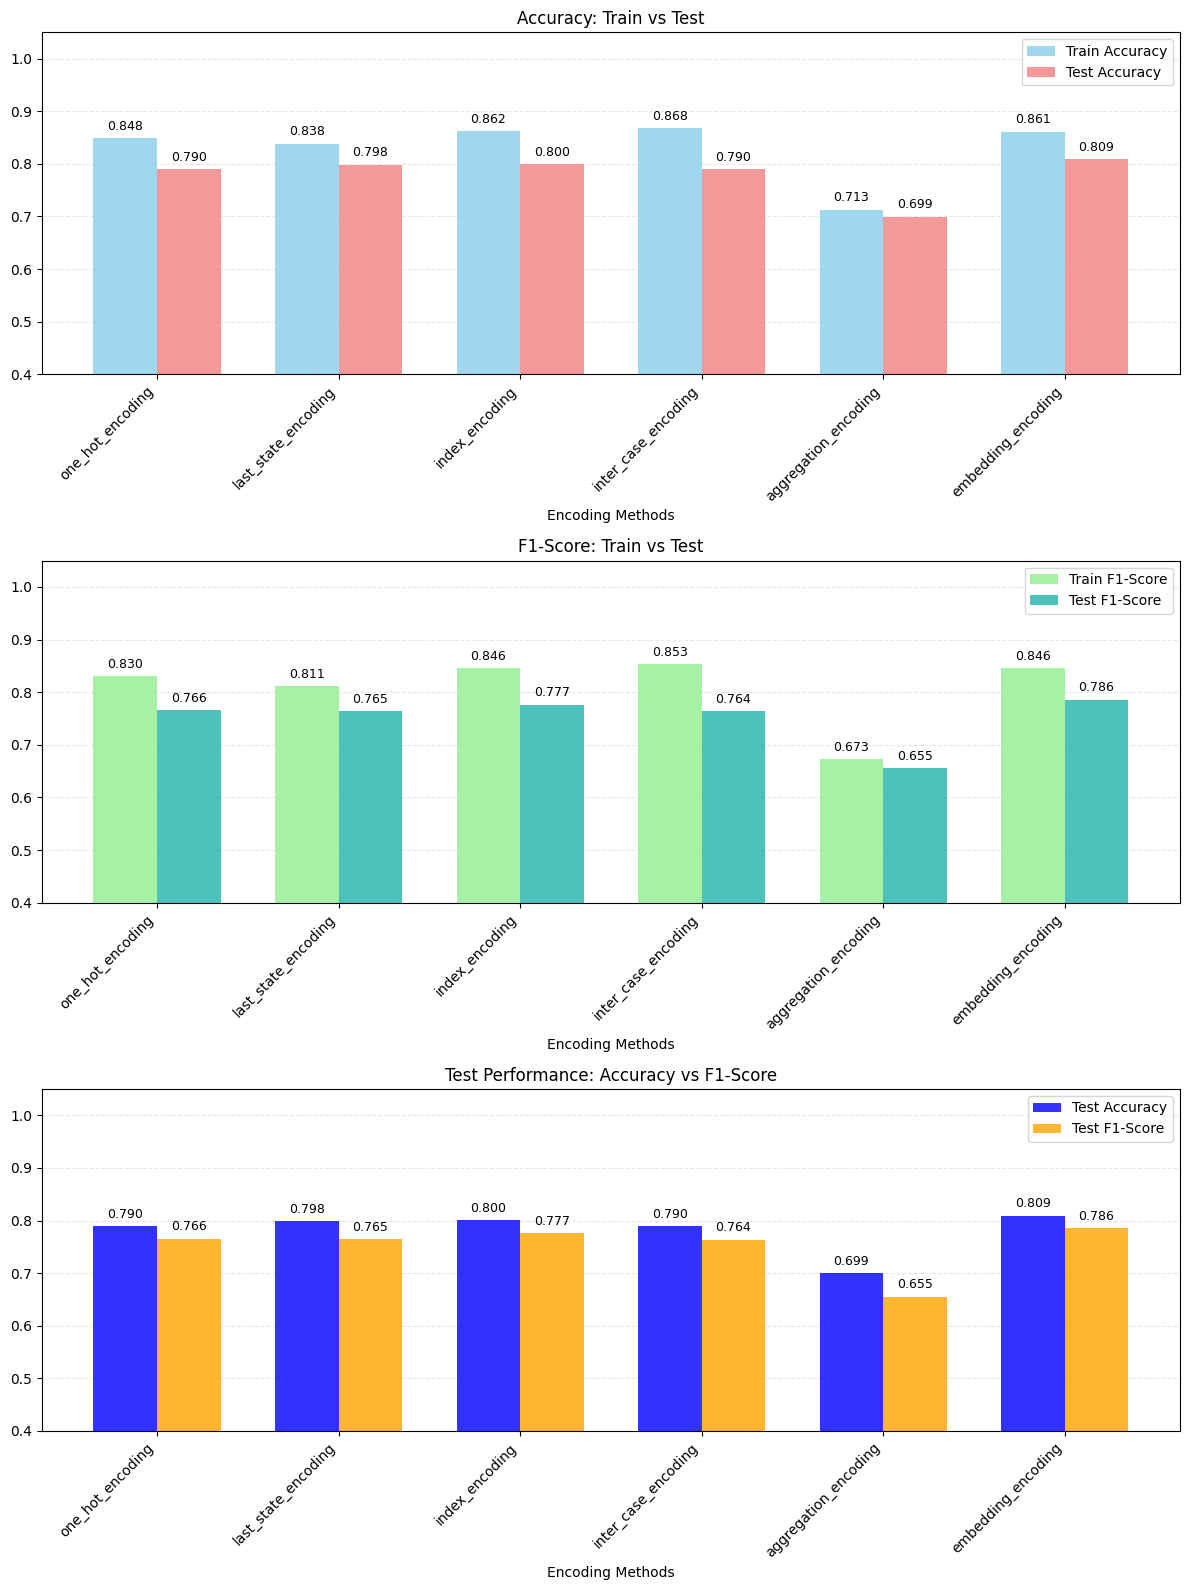

In [30]:
encodings = [result["encoding"] for result in results]

train_accuracies = [result["train_accuracy"] for result in results]
test_accuracies = [result["test_accuracy"] for result in results]

train_f1_scores = [result["train_f1"] for result in results]
test_f1_scores = [result["test_f1"] for result in results]

x = np.arange(len(encodings))
width = 0.35
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))

# Accuracy subplot
bars1_train = ax1.bar(x - width/2, train_accuracies, width, label="Train Accuracy", alpha=0.8, color="skyblue")
bars1_test = ax1.bar(x + width/2, test_accuracies, width, label="Test Accuracy", alpha=0.8, color="lightcoral")

for i, (bar_train, bar_test) in enumerate(zip(bars1_train, bars1_test)):
    ax1.text(bar_train.get_x() + bar_train.get_width()/2, bar_train.get_height() + 0.01, 
            f"{train_accuracies[i]:.3f}", ha="center", va="bottom", fontsize=9)
    ax1.text(bar_test.get_x() + bar_test.get_width()/2, bar_test.get_height() + 0.01, 
            f"{test_accuracies[i]:.3f}", ha="center", va="bottom", fontsize=9)

ax1.set_title("Accuracy: Train vs Test")
ax1.set_axisbelow(True)
ax1.set_xlabel("Encoding Methods")
ax1.set_xticks(x)
ax1.set_xticklabels(encodings, rotation=45, ha="right")
ax1.set_ylim(0.4, 1.05)
ax1.set_yticks(np.arange(0.4, 1.1, 0.1))
ax1.grid(axis="y", linestyle="--", alpha=0.3)
ax1.legend()

# F1-Score subplot
bars2_train = ax2.bar(x - width/2, train_f1_scores, width, label="Train F1-Score", alpha=0.8, color="lightgreen")
bars2_test = ax2.bar(x + width/2, test_f1_scores, width, label="Test F1-Score", alpha=0.8, color="lightseagreen")

for i, (bar_train, bar_test) in enumerate(zip(bars2_train, bars2_test)):
    ax2.text(bar_train.get_x() + bar_train.get_width()/2, bar_train.get_height() + 0.01, 
            f"{train_f1_scores[i]:.3f}", ha="center", va="bottom", fontsize=9)
    ax2.text(bar_test.get_x() + bar_test.get_width()/2, bar_test.get_height() + 0.01, 
            f"{test_f1_scores[i]:.3f}", ha="center", va="bottom", fontsize=9)

ax2.set_title("F1-Score: Train vs Test")
ax2.set_axisbelow(True)
ax2.set_xlabel("Encoding Methods")
ax2.set_xticks(x)
ax2.set_xticklabels(encodings, rotation=45, ha="right")
ax2.set_ylim(0.4, 1.05)
ax2.set_yticks(np.arange(0.4, 1.1, 0.1))
ax2.grid(axis="y", linestyle="--", alpha=0.3)
ax2.legend()

# evaluation (Accuracy vs F1-Score)
bars3_acc = ax3.bar(x - width/2, test_accuracies, width, label="Test Accuracy", alpha=0.8, color="blue")
bars3_f1 = ax3.bar(x + width/2, test_f1_scores, width, label="Test F1-Score", alpha=0.8, color="orange")

for i, (bar_acc, bar_f1) in enumerate(zip(bars3_acc, bars3_f1)):
    ax3.text(bar_acc.get_x() + bar_acc.get_width()/2, bar_acc.get_height() + 0.01, 
            f"{test_accuracies[i]:.3f}", ha="center", va="bottom", fontsize=9)
    ax3.text(bar_f1.get_x() + bar_f1.get_width()/2, bar_f1.get_height() + 0.01, 
            f"{test_f1_scores[i]:.3f}", ha="center", va="bottom", fontsize=9)

ax3.set_title("Test Performance: Accuracy vs F1-Score")
ax3.set_axisbelow(True)
ax3.set_xlabel("Encoding Methods")
ax3.set_xticks(x)
ax3.set_xticklabels(encodings, rotation=45, ha="right")
ax3.set_ylim(0.4, 1.05)
ax3.set_yticks(np.arange(0.4, 1.1, 0.1))
ax3.grid(axis="y", linestyle="--", alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

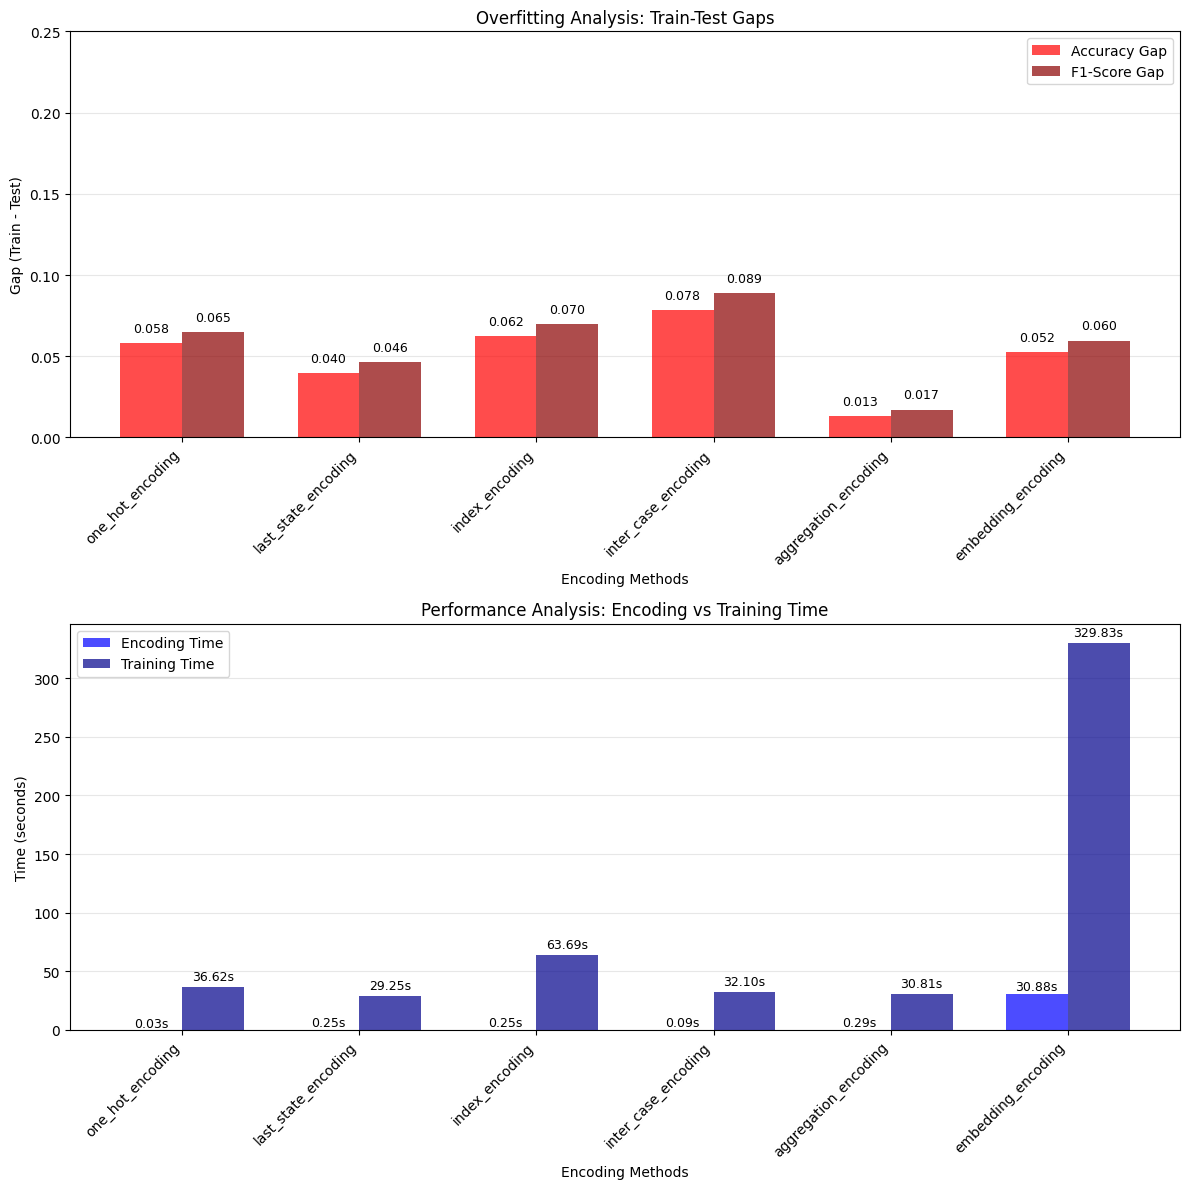

In [31]:
encodings = [result["encoding"] for result in results]
accuracy_gaps = [result["accuracy_gap"] for result in results]
f1_gaps = [result["f1_gap"] for result in results]
encoding_times = [result["encoding_time"] for result in results]
training_times = [result["training_time"] for result in results]

x = np.arange(len(encodings))
width = 0.35
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# overfitting analysis
bars1 = ax1.bar(x - width/2, accuracy_gaps, width, label="Accuracy Gap", color="red", alpha=0.7)
bars2 = ax1.bar(x + width/2, f1_gaps, width, label="F1-Score Gap", color="darkred", alpha=0.7)

for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f"{accuracy_gaps[i]:.3f}", ha="center", va="bottom", fontsize=9)
for i, bar in enumerate(bars2):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f"{f1_gaps[i]:.3f}", ha="center", va="bottom", fontsize=9)

ax1.set_ylim(0, 0.25)
ax1.set_title("Overfitting Analysis: Train-Test Gaps")
ax1.set_axisbelow(True)
ax1.set_xlabel("Encoding Methods")
ax1.set_ylabel("Gap (Train - Test)")
ax1.set_xticks(x)
ax1.set_xticklabels(encodings, rotation=45, ha="right")
ax1.legend()
ax1.grid(axis="y", alpha=0.3)

# performance analysis
bars3 = ax2.bar(x - width/2, encoding_times, width, label="Encoding Time", color="blue", alpha=0.7)
bars4 = ax2.bar(x + width/2, training_times, width, label="Training Time", color="darkblue", alpha=0.7)

for i, bar in enumerate(bars3):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(encoding_times)*0.01, 
             f"{encoding_times[i]:.2f}s", ha="center", va="bottom", fontsize=9)
for i, bar in enumerate(bars4):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01, 
             f"{training_times[i]:.2f}s", ha="center", va="bottom", fontsize=9)

ax2.set_title("Performance Analysis: Encoding vs Training Time")
ax2.set_axisbelow(True)
ax2.set_xlabel("Encoding Methods")
ax2.set_ylabel("Time (seconds)")
ax2.set_xticks(x)
ax2.set_xticklabels(encodings, rotation=45, ha="right")
ax2.legend()
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()